#Анализ расхода воды

Для водоснабжающих организаций актуальна проблема раннего обнаружения порывов утечек на водопроводных насосных станциях (ВНС).

Обычно подобные ситуации обнаруживаются при превышении установленных аварийных порогов (при наличии систем автоматики и диспетчеризации), либо по сообщениям в диспетчерскую службу. У обоих этих случаев есть серьёзные недостатки:
- расход колеблется в течении суток, то есть аварийные пороги в системах автоматики выставляются таким образом, чтобы суточные колебания не выходили за них
- если о порыве соообщили в диспетчерскую, значит он уже достаточно обширный, его устранение значительных сил и ресурсов, а также, скорее всего, длительного перекрытия воды потребителю.

Для обнаружения утечек и незаконных врезок можно использовать предсказательную модель. Такая модель будет обучаться на данных из системы диспетчеризации и сигнализировать о выходе текущего расхода за рамки доверительного интервала.

Предсказания будем выполнять с горизонтом в 1 сутки, с доверительным интервалом в 5%

# Импорт

In [1]:
#miscellaneous
import logging
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm.notebook import tqdm

#EDA
from ydata_profiling.visualisation.plot import timeseries_heatmap
from ydata_profiling import ProfileReport

#preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from category_encoders.m_estimate import MEstimateEncoder



#models
from prophet import Prophet

#metrics and evaluation
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

In [2]:
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [3]:
#plt.style.use('default')

In [4]:
plt.rcParams["figure.figsize"] = (16, 7)

# Загрузка данных

In [5]:
def read_data(file_path):
  df = pd.read_csv(file_path, sep = '\t')
  df.columns = df.columns.str.lower()
  df = df[['time', 'value']]
  df['value'] = df['value'].str.replace(' м³/ч', '').astype(float)
  df['time'] = pd.to_datetime(df['time'], format = '%d/%m/%Y %H:%M:%S')
  return df

In [6]:
df = read_data('/content/drive/MyDrive/DS/datasets/flow_example/q1.csv')
df.head()

,time,value
0,2023-06-23 14:02:00,26.4
1,2023-06-23 14:01:00,20.6
2,2023-06-23 14:00:00,25.1
3,2023-06-23 13:59:00,19.7
4,2023-06-23 13:58:00,20.3


In [7]:
df2 = read_data('/content/drive/MyDrive/DS/datasets/flow_example/q2.csv')
df2.head()

,time,value
0,2022-12-31 23:59:00,7.4
1,2022-12-31 23:58:00,7.7
2,2022-12-31 23:57:00,8.1
3,2022-12-31 23:56:00,7.8
4,2022-12-31 23:55:00,0.0


Данные загружены без ошибок. Соединим датафреймы в один и удалим лишние переменные

In [8]:
df = pd.concat([df, df2])
del df2

# Предобработка

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529872 entries, 0 to 280271
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    529872 non-null  datetime64[ns]
 1   value   529872 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 MB


Явных пропусков нет, преобразования типов данных не требуются

In [10]:
df['time'].is_monotonic_decreasing

True

Значения времени в датафрейме монотонно убывают. Отсортируем их по возрастанию.

In [11]:
df = df.sort_values(by = 'time', ascending = True)
df = df.reset_index(drop = True)
df['time'].is_monotonic_increasing

True

In [12]:
df['time'].describe()

<ipython-input-12-5b7f04f9d4e6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['time'].describe()


count                  529872
unique                 529852
top       2023-01-27 10:48:00
freq                        3
first     2022-01-14 14:31:47
last      2023-06-23 14:02:00
Name: time, dtype: object

# EDA

In [13]:
df['value'].describe()

count    529872.000000
mean         22.982941
std          10.891722
min         -50.200000
25%          16.100000
50%          25.700000
75%          30.800000
max          72.300000
Name: value, dtype: float64

В датафрейме представлены данные за период с 14 января 2022 года по 23 июня 2023

<Axes: xlabel='time'>

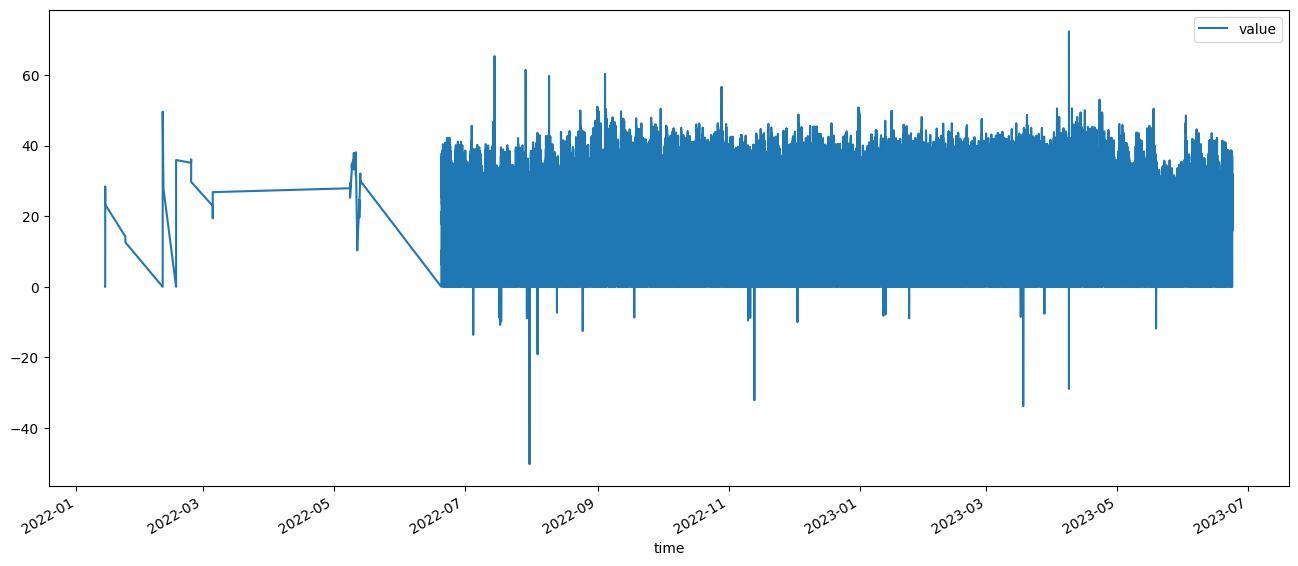

In [14]:
df.plot(x = 'time', y = 'value')

За период с января по июль 2022 года наблюдается большое количество отсутствующих данных. Анализировать этот период бесполезно, поэтому просто удалим его.

In [15]:
df = df[df['time'] > '2022-07'].reset_index(drop = True)

Выполним ресемплинг. Поскольку мы установили горизонт предсказания в 1 день, будет разумным принять частоту ресемплинга в 1 час. Пропуски в получившемся датафрейме заполним интерполированными значениями.

In [16]:
df = df.resample('1H', on = 'time').mean()

In [17]:
df = df.interpolate()

In [18]:
df.head()

,value
time,
2022-07-01 00:00:00,9.306780
2022-07-01 01:00:00,4.845000
2022-07-01 02:00:00,0.226667
2022-07-01 03:00:00,0.253333
2022-07-01 04:00:00,6.906897


<Axes: xlabel='time'>

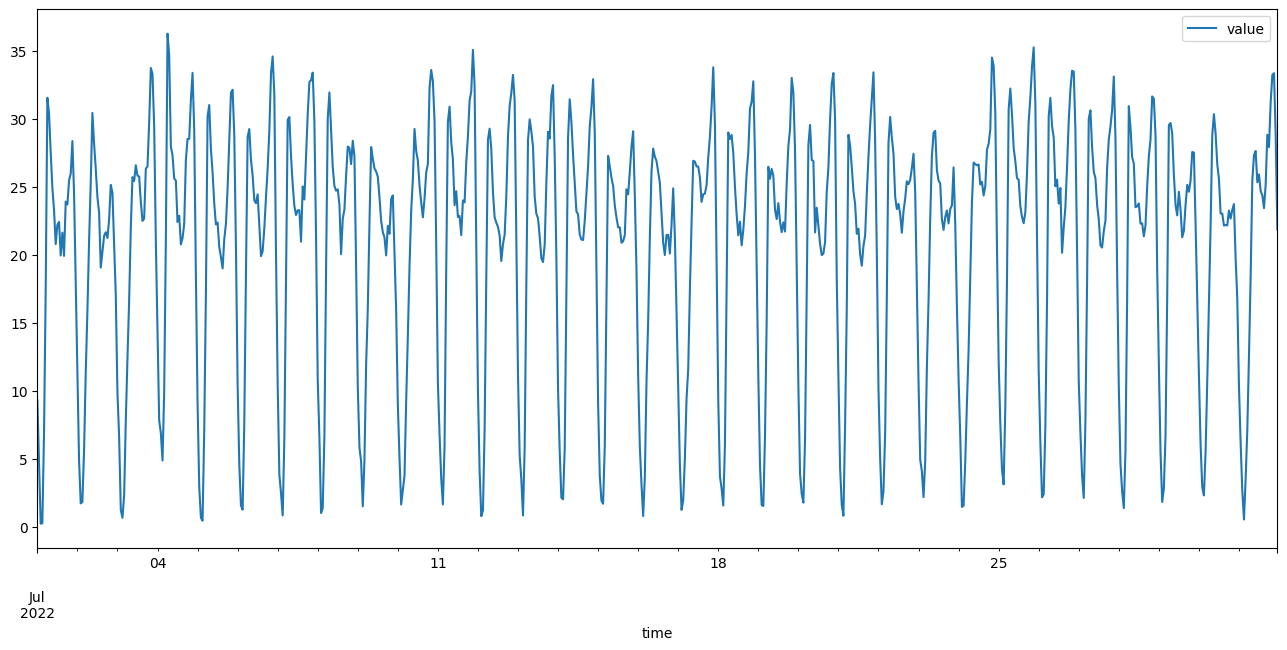

In [19]:
df.loc['2022-07'].plot()

Проведём декомпозицию

In [20]:
decomposed = seasonal_decompose(df)

<Axes: xlabel='time'>

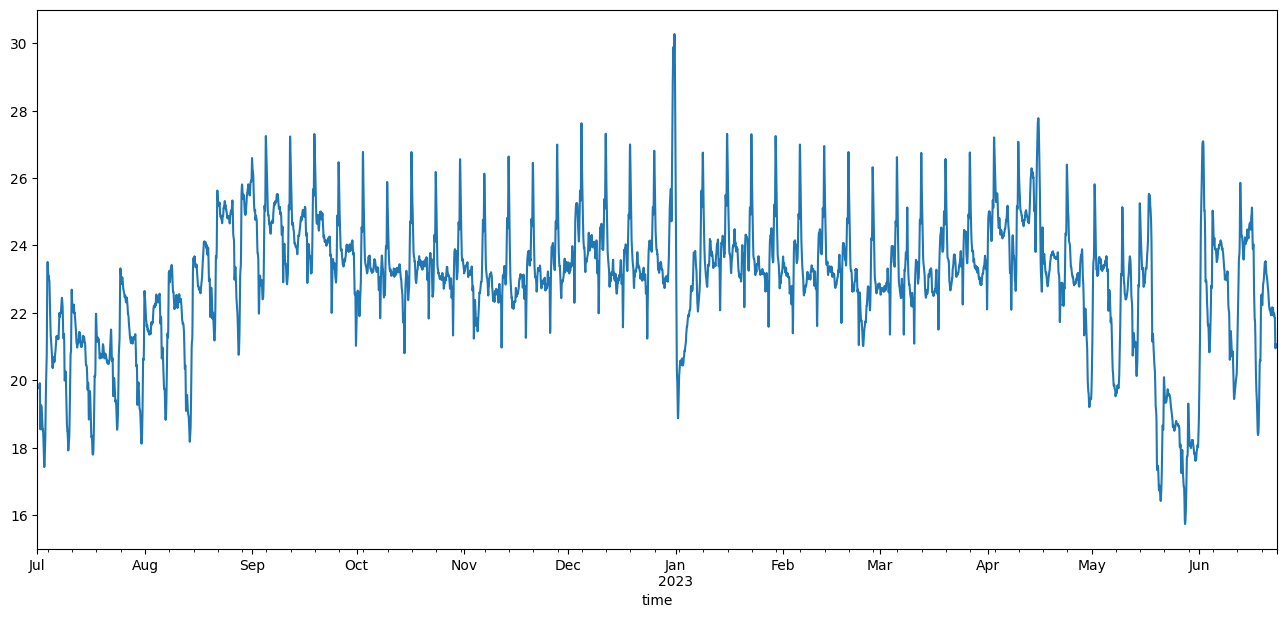

In [21]:
decomposed.trend.plot()

На тренде заметен рост в районе сентября и спад в середине апреля. Это примерное время отопительного сезона, во время которого котельные и тепловые пункты действительно создают повышенный расход.

<Axes: xlabel='time'>

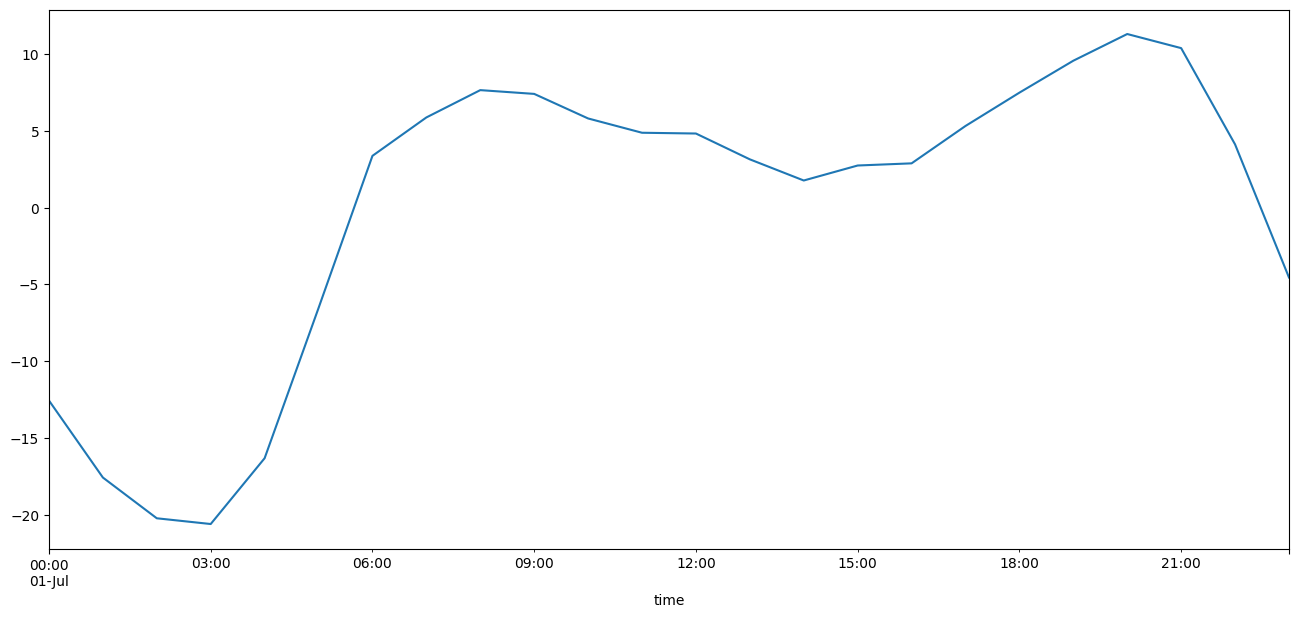

In [22]:
decomposed.seasonal.loc['2022-07-01'].plot()

График суточной сезонности показывает пики расхода утром и вечером. Подобные графики можно наблюдать на любой ВНС, отвечающей за водоснабжение жилых районов.

In [23]:
decomposed.resid.describe()

count    8559.000000
mean       -0.001020
std         3.149179
min       -17.743380
25%        -1.750456
50%        -0.171325
75%         1.841867
max        12.239821
Name: resid, dtype: float64

# Обучение модели



Модели prophet на вход подаётся датафрейм с двумя колонками - ds (время) и y (значения)

In [24]:
df = df.reset_index(drop = False)
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2022-07-01 00:00:00,9.306780
1,2022-07-01 01:00:00,4.845000
2,2022-07-01 02:00:00,0.226667
3,2022-07-01 03:00:00,0.253333
4,2022-07-01 04:00:00,6.906897


##Cold start

Обучим модель с дефолтными значениями гиперпараметров.

In [25]:
model = Prophet()
model.fit(df)

Отобразим компоненты предсказаний и посмотрим, насколько они отображают виденные нами ранее закономерности

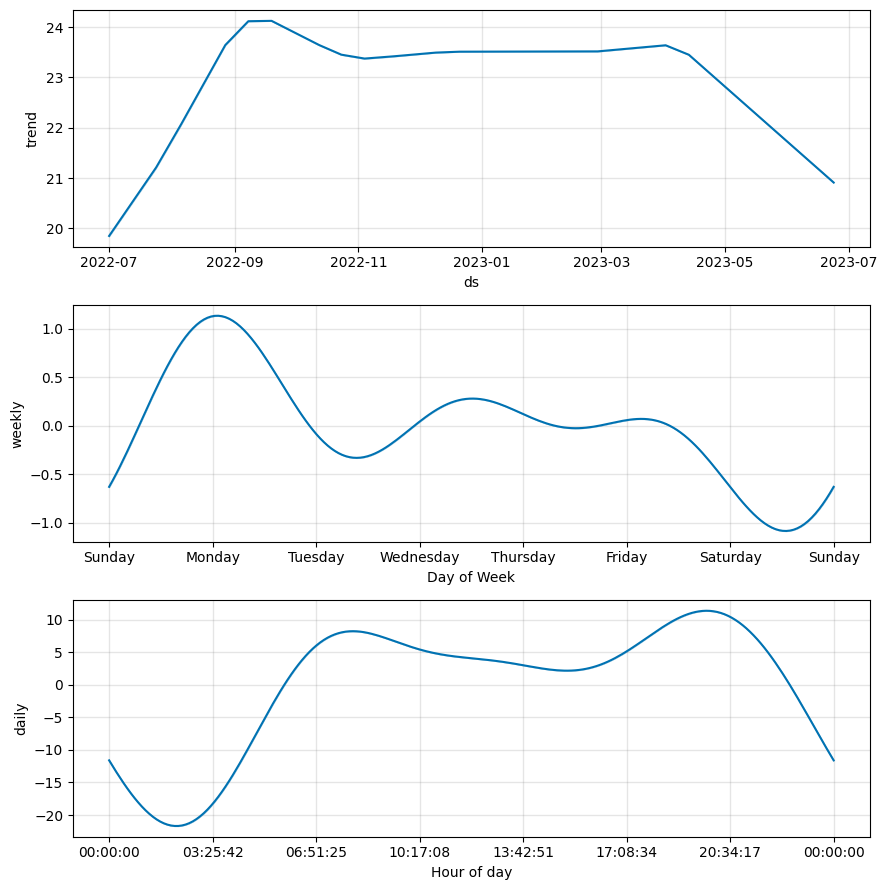

In [26]:
forecast = model.predict(df)
fig = model.plot_components(forecast)

Хорошо отобажены годовой тренд и суточная сезонность (недельная сезонность в диапазоне -1 до 1 м³/ч не оказывает сильного влияния на результат)

In [27]:
df_cv = cross_validation(model, horizon='1 day', parallel="processes")

In [28]:
df_p = performance_metrics(df_cv)
df_p['mape'].describe()

count    22.000000
mean      0.181955
std       0.083131
min       0.089160
25%       0.111943
50%       0.170675
75%       0.240547
max       0.362661
Name: mape, dtype: float64

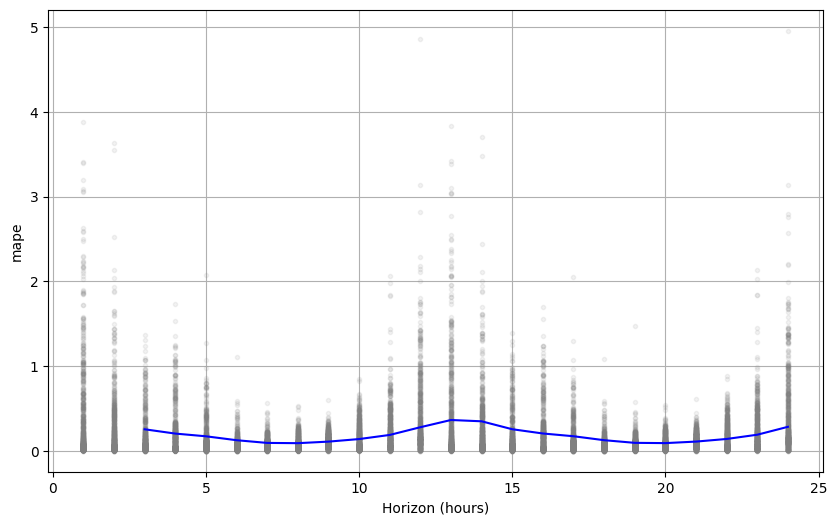

In [29]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

Запуск модели с дефолтными пакраметрами даёт неплохие результаты - mape < 5%, то есть предсказания модели лежат в пределах установленного доверительного интервала.

## Fine-tuning

Можно попытаться улучшить результат подбором гиперпараметров. Рекомендованные параметры - `changepoint_prior_scale`, `seasonality_prior_scale` и `seasonality_mode` ([документация fbprophet](https://facebook.github.io/prophet/docs/diagnostics.html)).

In [30]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.15],
    'seasonality_prior_scale': [10],
    'seasonality_mode': ['multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here
cv_results = []
metrics = []
min_mape = 100
best_model = None

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv_gs = cross_validation(m, horizon='1 day', parallel="processes")
    df_p_gs = performance_metrics(df_cv_gs)
    metrics.append(df_p_gs)
    cv_results.append(df_cv_gs)
    if df_p_gs['mape'].mean() < min_mape:
      min_mape = df_p_gs['mape'].mean()
      best_model = m

    mapes.append(df_p_gs['mape'].mean())

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape
0,0.05,10,multiplicative,0.170402
1,0.10,10,multiplicative,0.170336
2,0.15,10,multiplicative,0.170362


In [32]:
best = tuning_results[tuning_results['mape'] == tuning_results['mape'].min()]
best

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape
1,0.1,10,multiplicative,0.170336


In [33]:
metrics[best.index[0]]['mape'].describe()

count    22.000000
mean      0.170336
std       0.067328
min       0.090948
25%       0.112716
50%       0.170441
75%       0.218157
max       0.309927
Name: mape, dtype: float64

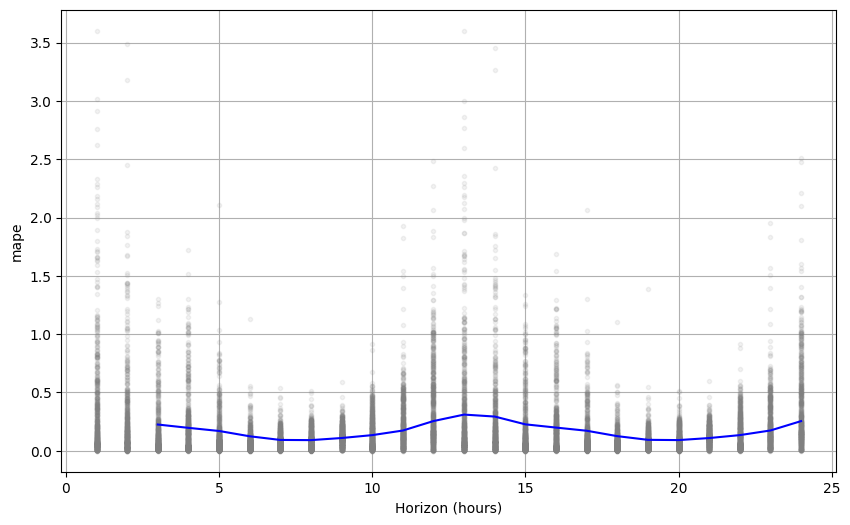

In [34]:
fig = plot_cross_validation_metric(cv_results[best.index[0]], metric='mape')

Оценим, насколько изменились характеристики распределения MAPE

In [35]:
(metrics[best.index[0]]['mape'].describe() - df_p['mape'].describe()).loc[['mean', 'std', '50%']]

mean   -0.011619
std    -0.015803
50%    -0.000234
Name: mape, dtype: float64

Среднее значение MAPE и среднеквадратическое отклонение снизились на 0.01%, предсказания стали более точными и более стабильными. Медианное значение MAPE практически не изменилось

# Вывод

Обученная модель позволяет делать предсказания расхода с MAPE = 0.17%.

Данная модель обучена всего для одной точки и не подойдёт для предсказания на других объектах (коих по городу насчитываются десятки, по 1-4 точки на каждом). Однако на подавляющей их части будут наблюдаться одинаковые зависимости (суточные пики утром и вечером и рост расхода в отопительные сезон), что позволяет не проводить подбор гиперпараметров для каждой точки.